In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "32"

In [3]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS
import matplotlib.pyplot as plt
import matplotlib.cm as mpl
import seaborn as sns
import statsmodels.api as sm
from multipy.fdr import qvalue
from multipy.fdr import lsu

import dill

import fit_sbm
import trim_networks
import export_blocks

In [4]:
with open ("../data/output/SBM/clustering/body_weights-spearman_fdr-1e-03_mcmc_mode_hierarchical-SBM.dill", "rb") as fh:
    bs_body = dill.load(fh)
bs_body = bs_body[0:5]

In [5]:
gf_body = load_graph("../data/output/SBM/graphs/body_fdrLevel-0.001_genes-5124_density-0.059.xml.gz")
corr = gf_body.edge_properties["spearman"]

gf_body.ep.z_s = gf_body.new_edge_property("double", (2*np.arctanh(corr.a)))

block_df_body = pd.read_csv("../data/output/SBM/clustering/body_weights-spearman_fdr-1e-03_mcmc_mode_hierarchical-SBM.csv")

state_body = minimize_nested_blockmodel_dl(gf_body, init_bs=bs_body, 
                                      state_args=dict(recs=[gf_body.ep.z_s],
                                                      rec_types=["real-normal"]))

In [6]:
with open ("../data/output/SBM/clustering/head_weights-spearman_fdr-1e-02_mcmc_mode_hierarchical-SBM.dill", "rb") as fh:
    bs_head = dill.load(fh)
bs_head = bs_head[0:5]

In [7]:
gf_head = load_graph("../data/output/SBM/graphs/head_fdrLevel-0.01_genes-5261_density-0.033.xml.gz")
corr = gf_head.edge_properties["spearman"]

gf_head.ep.z_s = gf_head.new_edge_property("double", (2*np.arctanh(corr.a)))

block_df_head = pd.read_csv("../data/output/SBM/clustering/head_weights-spearman_fdr-1e-02_mcmc_mode_hierarchical-SBM.csv")

state_head = minimize_nested_blockmodel_dl(gf_head, init_bs=bs_head, 
                                      state_args=dict(recs=[gf_head.ep.z_s],
                                                      rec_types=["real-normal"]))

In [ ]:
for i in set(state_head.get_bs()[1]):
    is_block_1 = state_head.get_bs()[1][state_head.get_bs()[0]] == i
    is_block_1 = np.array(is_block_1) + 1
    gf_head.vp.show_vertex = gf_head.new_vertex_property("double", (is_block_1 - 1) * 10 + 1)
        
    state_head.draw(edge_color=prop_to_size(gf_head.ep.z_s, mi=-4, ma=4, power=1, log=False),
                    ecmap=(mpl.inferno, .6), edge_gradient=[], 
                    vertex_size = 4,
                    hvertex_size = 10,
                    hedge_pen_width = 2,
                    #vertex_text = state_head.get_bs()[0], 
                    vertex_color = gf_head.vp.show_vertex,
                    vertex_fill_color = gf_head.vp.show_vertex,
                    eorder=gf_head.ep.z_s,
                    subsample_edges = 30000,
                    output = "../data/output/SBM/guide_plots/head/fdr-1e-02/" + str(i).zfill(2) + ".png") 

gf_head.vp.level_1 = gf_head.new_vertex_property("double", state_head.get_bs()[1][state_head.get_bs()[0]])
state_head.draw(
            eorder=gf_head.ep.z_s,
            #edge_pen_width = gf_head.ep.z_s,
            edge_color=prop_to_size(gf_head.ep.z_s, mi=-4, ma=4, power=1, log=False),
            ecmap=(mpl.inferno, .6), 
            edge_gradient=[], 
            vertex_size = 4,
            hvertex_size = 10,
            hedge_pen_width = 2,
            vertex_color = gf_head.vp.level_1,
            vertex_fill_color = gf_head.vp.level_1,
            subsample_edges = 30000,
            output = "../data/output/SBM/guide_plots/head/fdr-1e-02/full_plot.png")

In [ ]:
for i in set(state_body.get_bs()[1]):
    is_block_1 = state_body.get_bs()[1][state_body.get_bs()[0]] == i
    is_block_1 = np.array(is_block_1) + 1
    gf_body.vp.show_vertex = gf_body.new_vertex_property("double", (is_block_1 - 1) * 10 + 1)
        
    state_body.draw(edge_color=prop_to_size(gf_body.ep.z_s, mi=-4, ma=4, power=1, log=False),
                    ecmap=(mpl.inferno, .6), edge_gradient=[], 
                    vertex_size = 4,
                    hvertex_size = 10,
                    hedge_pen_width = 2,
                    #vertex_text = state_body.get_bs()[0], 
                    vertex_color = gf_body.vp.show_vertex,
                    vertex_fill_color = gf_body.vp.show_vertex,
                    eorder=gf_body.ep.z_s,
                    subsample_edges = 30000,
                    output = "../data/output/SBM/guide_plots/body/fdr-1e-03/" + str(i).zfill(2) + ".png") 

gf_body.vp.level_1 = gf_body.new_vertex_property("double", state_body.get_bs()[1][state_body.get_bs()[0]])
state_body.draw(
            eorder=gf_body.ep.z_s,
            #edge_pen_width = gf_body.ep.z_s,
            edge_color=prop_to_size(gf_body.ep.z_s, mi=-4, ma=4, power=1, log=False),
            ecmap=(mpl.inferno, .6), 
            edge_gradient=[], 
            vertex_size = 4,
            hvertex_size = 10,
            hedge_pen_width = 2,
            vertex_color = gf_body.vp.level_1,
            vertex_fill_color = gf_body.vp.level_1,
            subsample_edges = 30000,
            output = "../data/output/SBM/guide_plots/body/fdr-1e-03/full_plot.png")

In [140]:
for i in set(state_body.get_bs()[0]):
    is_block_1 = state_body.get_bs()[0] == i
    is_block_1 = np.array(is_block_1) + 1
    gf_body.vp.show_vertex = gf_body.new_vertex_property("double", (is_block_1 - 1) * 10 + 1)
        
    state_body.draw(edge_color=prop_to_size(gf_body.ep.z_s, mi=-4, ma=4, power=1, log=False),
                    ecmap=(mpl.inferno, .6), edge_gradient=[], 
                    vertex_size = 2,
                    hvertex_size = 10,
                    hedge_pen_width = 2,
                    #vertex_text = state_body.get_bs()[0], 
                    vertex_color = gf_body.vp.show_vertex,
                    vertex_fill_color = gf_body.vp.show_vertex,
                    eorder=gf_body.ep.z_s,
                    subsample_edges = 30000,
                    output = "../data/output/SBM/guide_plots/body/fdr-1e-03/Level0_" + str(i).zfill(2) + ".png") 


In [141]:
for i in set(state_head.get_bs()[0]):
    is_block_1 = state_head.get_bs()[0] == i
    is_block_1 = np.array(is_block_1) + 1
    gf_head.vp.show_vertex = gf_head.new_vertex_property("double", (is_block_1 - 1) * 10 + 1)
        
    state_head.draw(edge_color=prop_to_size(gf_head.ep.z_s, mi=-4, ma=4, power=1, log=False),
                    ecmap=(mpl.inferno, .6), edge_gradient=[], 
                    vertex_size = 2,
                    hvertex_size = 10,
                    hedge_pen_width = 2,
                    #vertex_text = state_head.get_bs()[0], 
                    vertex_color = gf_head.vp.show_vertex,
                    vertex_fill_color = gf_head.vp.show_vertex,
                    eorder=gf_head.ep.z_s,
                    subsample_edges = 30000,
                    output = "../data/output/SBM/guide_plots/head/fdr-1e-02/Level0_" + str(i).zfill(2) + ".png") 


ValueError: Invalid vertex index: 18

In [139]:
len(state_body.get_bs()[0])

5124

In [60]:
adjacency(state_head.levels[0].bg, weight=state_head.levels[1].g.edge_properties['z_s'])


KeyError: ('e', 'z_s')

In [75]:
state_head.levels[3].get_matrix().todense()

matrix([[246814.,  85418.,  90339.],
        [ 85418., 106034.,  57456.],
        [ 90339.,  57456.,  93884.]])

In [115]:
tv = state_head.levels[0].bg
comp, hist = label_components(tv)
main_component = tv.new_vp("bool", (comp.a == np.where(hist == max(hist))[0][0]))
tv.vertex_properties["main_component"] = main_component
tv.set_vertex_filter(main_component)

In [116]:
connected = tv.new_ep("bool", (state_head.levels[0].mrs.a > 10))
tv.set_edge_filter(connected)

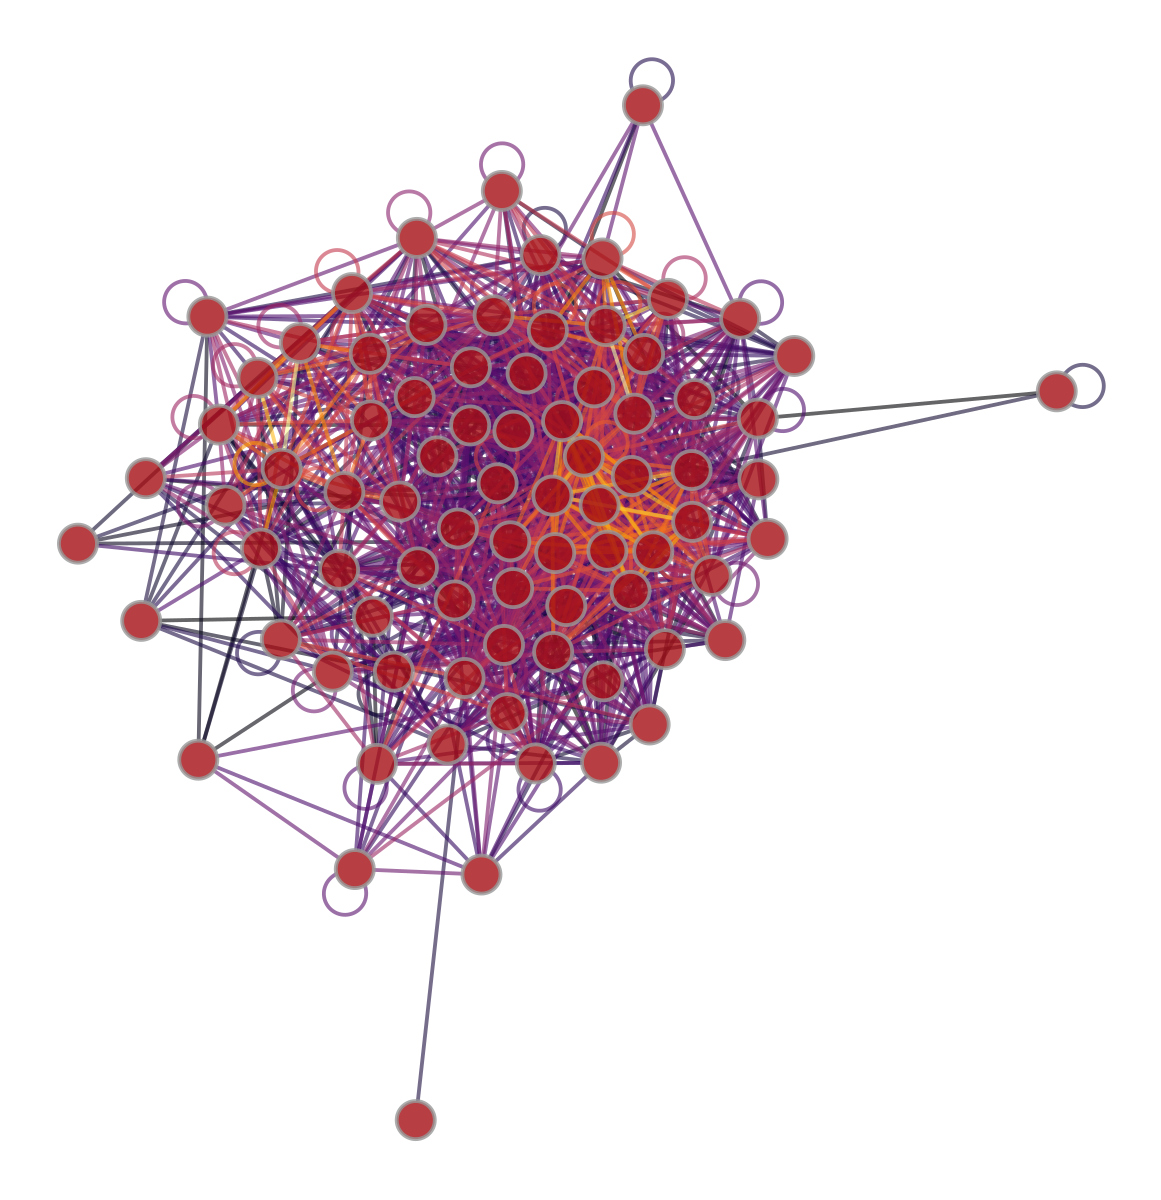

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f64ef278a30, at 0x7f64c772ac50>

In [118]:
graph_draw(tv, edge_color=prop_to_size(state_head.levels[0].mrs, power=1/2),
            eorder=state_head.levels[0].mrs,
            #edge_pen_width = gf_body.ep.z_s,
            ecmap=(mpl.inferno, .6), 
            edge_gradient=[], )